# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

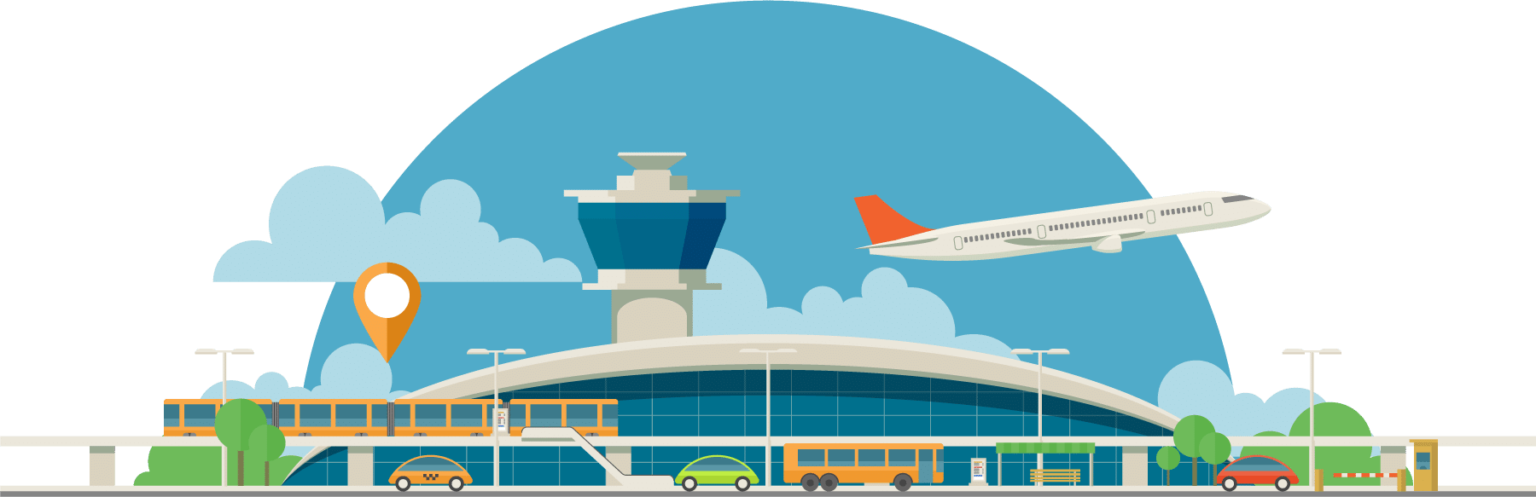

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-03-02 17:57:11--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-03-02 17:57:12 (1.27 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

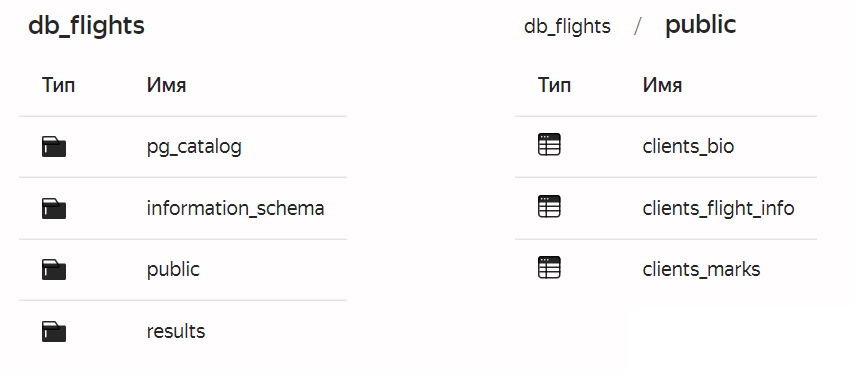



In [75]:
with psycopg2.connect(
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port=6432,
    sslmode="verify-full",
    dbname="db_flights",
    user="mlhs_student",
    password="mlhs_student",
    target_session_attrs="read-write"
) as conn:
    query = """
        SELECT *
        FROM public.clients_bio AS b
        JOIN public.clients_flight_info AS f USING (id)
        JOIN public.clients_marks AS m USING (id);
    """
    df = pd.read_sql(query, conn)

df.set_index('id', inplace=True)

<ipython-input-75-afa05ac84a05>:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [6]:
df.dtypes

gender                               object
age                                  object
Customer Type                        object
Type of Travel                       object
class                                object
Flight Distance                      object
Departure Delay in Minutes           object
Arrival Delay in Minutes             object
Inflight wifi service                object
Departure/Arrival time convenient    object
Ease of Online booking               object
Gate location                        object
Food and drink                       object
Online boarding                      object
Seat comfort                         object
Inflight entertainment               object
On-board service                     object
Leg room service                     object
Baggage handling                     object
Checkin service                      object
Inflight service                     object
cleanliness                          object
satisfaction                         object
dtype: object

In [7]:
# Преобразуем числовые столбцы в float
columns_float = [
    'age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'cleanliness',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
]

for col in columns_float:
    df[col] = df[col].astype(float)

df.dtypes

gender                                object
age                                  float64
Customer Type                         object
Type of Travel                        object
class                                 object
Flight Distance                      float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service                     float64
cleanliness                          float64
satisfaction                          object
dtype: object

In [8]:
# Пропуски
df = df.replace('nan', np.nan) # в object есть строки с nan
df[['age', 'Flight Distance']] = df[['age', 'Flight Distance']].replace(0, np.nan) # не может быть 0


missing_data = df.isna().sum()
print('Пропуски в столбцах:')
print(missing_data)

# Числовые
numeric_cols = df.select_dtypes(include='float').columns

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))

print('Выбросы в числовых столбцах:')
outliers.sum()

# Категориальные
categorical_cols = df.select_dtypes(include='object').columns
threshold = 0.05

for col in categorical_cols:
    value_counts = df[col].value_counts(normalize=True, dropna=True)
    rare_categories = value_counts[value_counts < threshold]

    if not rare_categories.empty:
        print(f"Столбец '{col}' - редкие категории (менее {threshold * 100}%):")
        print(rare_categories)
    else: print(f'Выбросы в {col} не обнаружены')

Пропуски в столбцах:
gender                                 0
age                                  374
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       98
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64
Выбросы в числовых стол

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

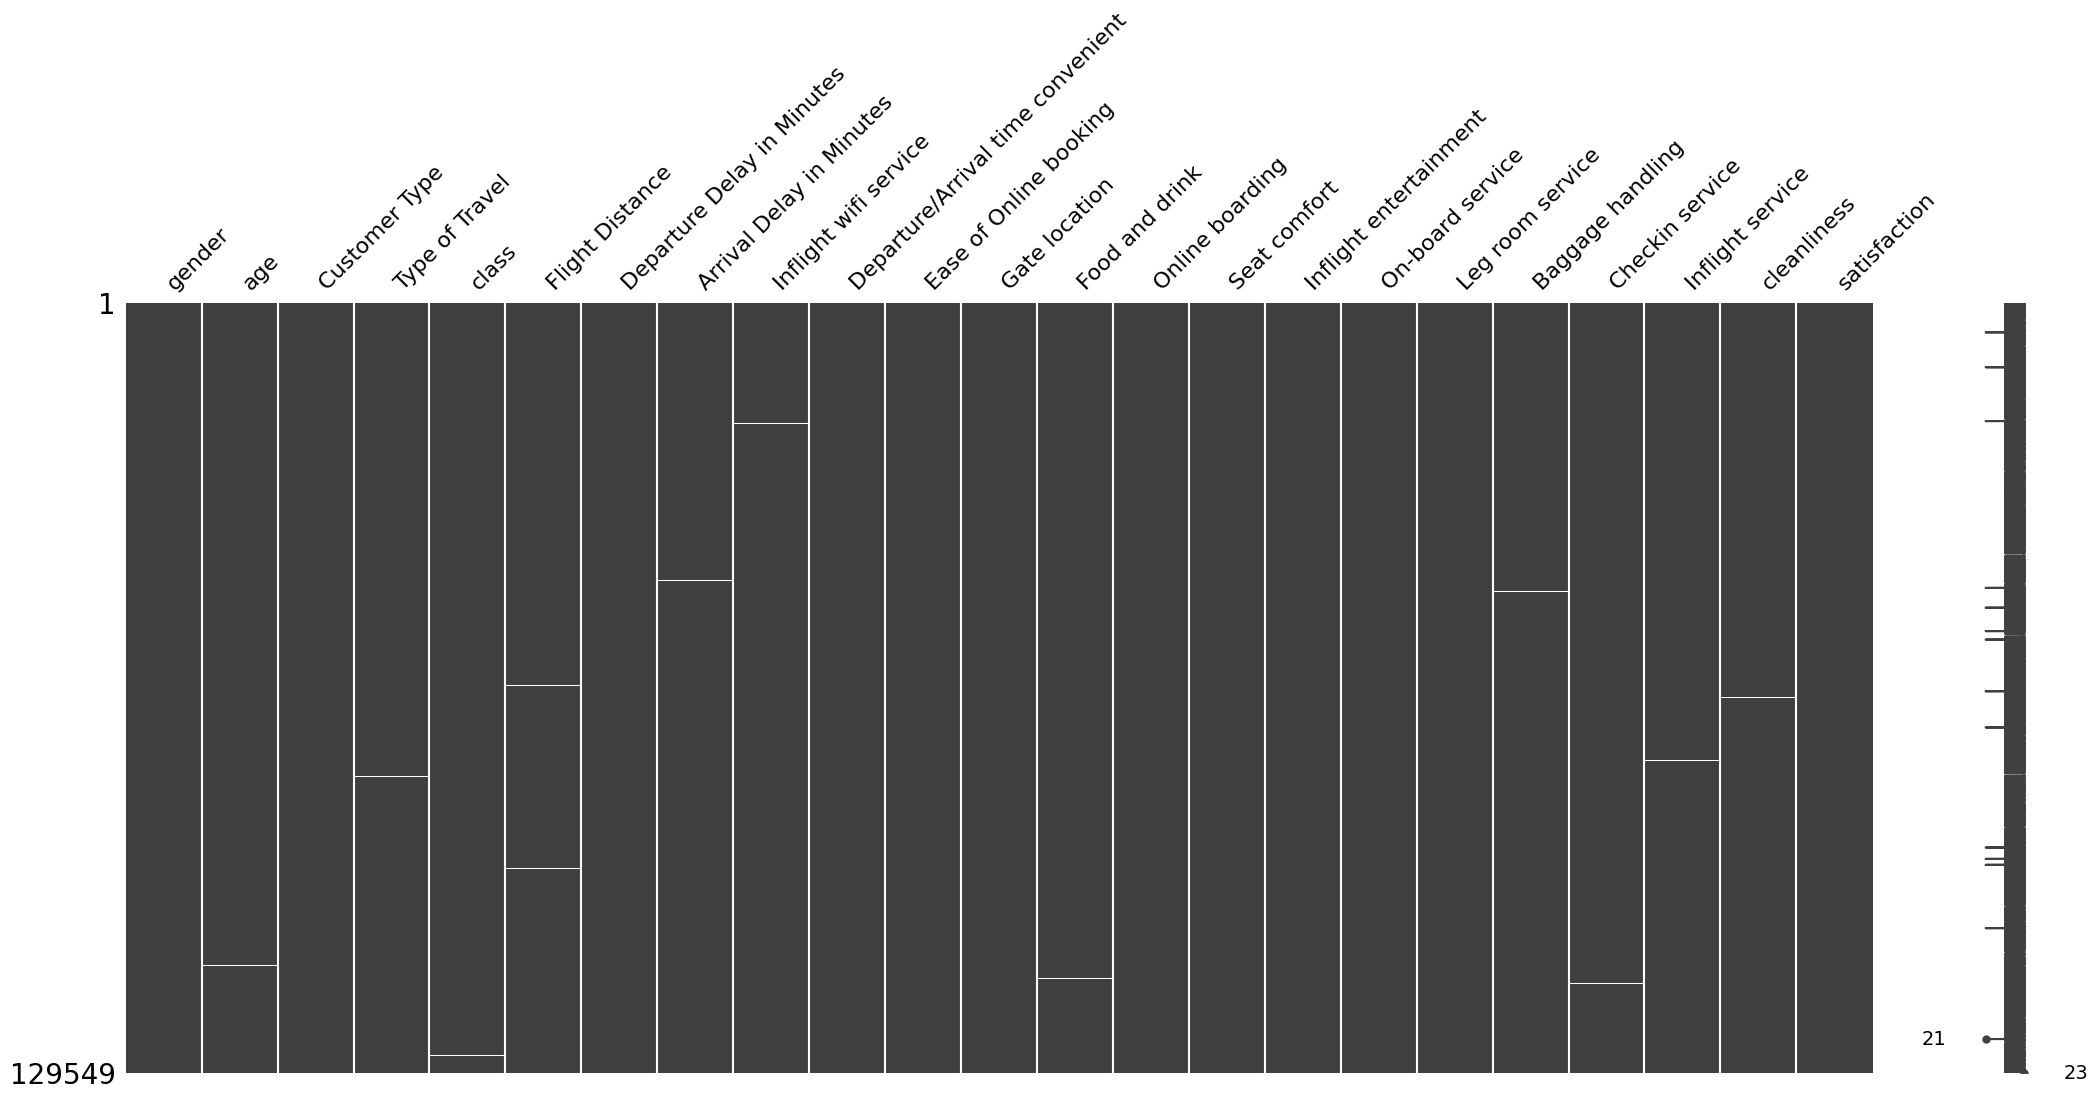

In [9]:
missingno.matrix(df)

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

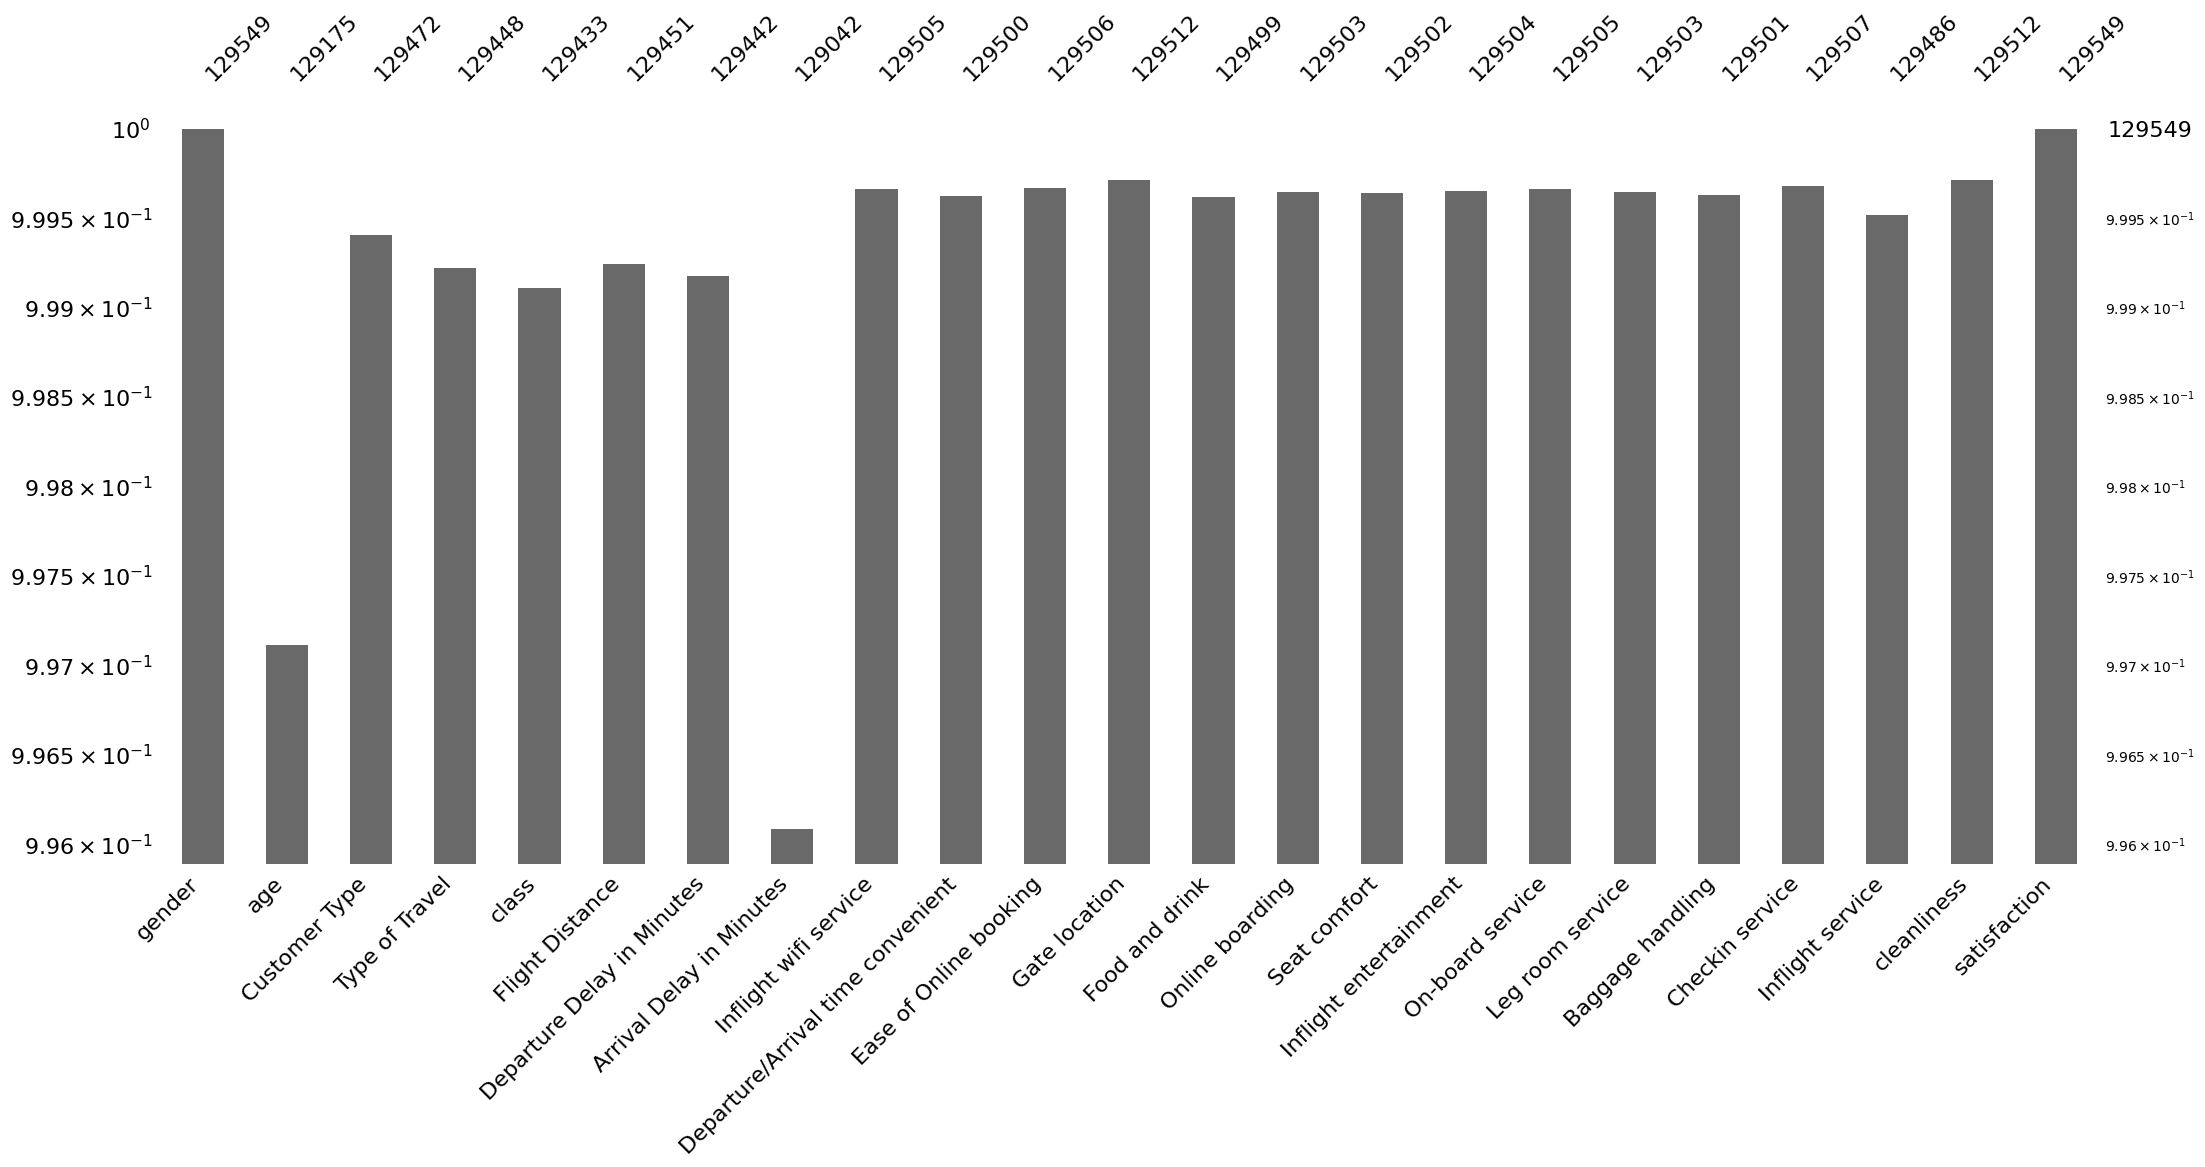

In [10]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [11]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [12]:
assert df_train.shape == (103_644, 23)

In [13]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [14]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [15]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [16]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [17]:
#Пропуски
missing_data = X_train.isna().sum()
print(missing_data)

gender                                 0
age                                  214
Customer Type                         52
Type of Travel                        70
class                                 66
Flight Distance                       56
Departure Delay in Minutes            61
Arrival Delay in Minutes             294
Inflight wifi service                 23
Departure/Arrival time convenient     28
Ease of Online booking                24
Gate location                         19
Food and drink                        22
Online boarding                       23
Seat comfort                          23
Inflight entertainment                30
On-board service                      23
Leg room service                      22
Baggage handling                      21
Checkin service                       22
Inflight service                      30
cleanliness                           21
dtype: int64


In [18]:
X_train = X_train.fillna(X_train.mode().iloc[0])

In [19]:
missing_data = X_train.isna().sum()
print(missing_data)

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [20]:
df.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  129175.000000    129451.000000               129442.000000   
mean       40.135274      1322.963036                   15.809026   
std        20.362732      4517.880346                   93.276882   
min         7.000000        31.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [21]:
df.describe(include=['object'])

gender   Customer Type   Type of Travel     class  \
count   129549          129472           129448    129433   
unique       2               2                2         3   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

В среднем наш клиент - 40 летние женщины, летающие в бизнес классе, чтобы решать вопросы по бизнесу, летают в среднем 1322 км(Москва-Сочи наверное)). Судя по всему у нас так себе сервис на борту(ср. знач. 3)  и частые задежки, но клиентам мы нравимся(лояльных клиентов большинство)

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [22]:
numeric_cols = X_train.select_dtypes(include=np.number).columns

quantiles_0_996 = {
    col: X_train[col].quantile(0.996)
    for col in numeric_cols
}

mask_train = pd.Series(True, index=X_train.index)
for col in numeric_cols:
    mask_train &= X_train[col] <= quantiles_0_996[col]

X_train = X_train[mask_train]
y_train = y_train[mask_train]

mask_val = pd.Series(True, index=X_val.index)
for col in numeric_cols:
    mask_val &= X_val[col] <= quantiles_0_996[col]

X_val = X_val[mask_val]
y_val = y_val[mask_val]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71395, 22), (71395,), (30189, 22), (30189,))

In [23]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [24]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [25]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [26]:
def plot_ordinal(cols, df, y):
    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue=y, palette='Dark2')
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Satisfaction', loc='best')
        plt.tight_layout()
        plt.show()


In [27]:
def plot_continuous(cols, df, y):
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        sns.kdeplot(data=df, x=col, hue=y, fill=True,
                    palette='Set2', common_norm=False, ax=axes[0])
        axes[0].set_title(f'KDE of {col}', fontsize=12)
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Плотность')

        sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])
        axes[1].set_title(f'{col} by satisfaction', fontsize=12)
        axes[1].set_xlabel('Satisfaction')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

In [28]:
def plot_categorical(cols, df, y):

    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue=y, palette='Set2')
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Satisfaction', loc='best')
        plt.tight_layout()
        plt.show()

Отрисовка.

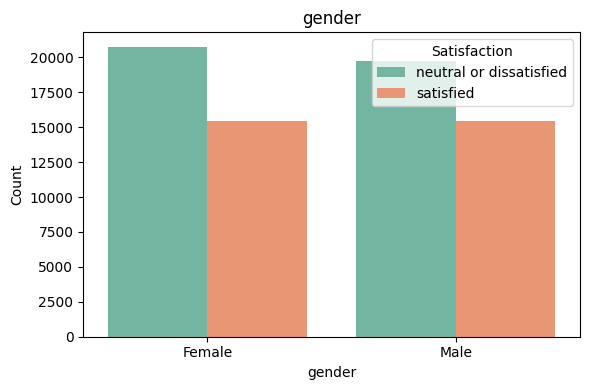

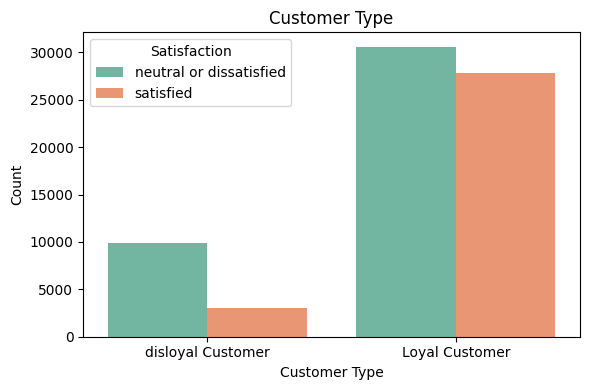

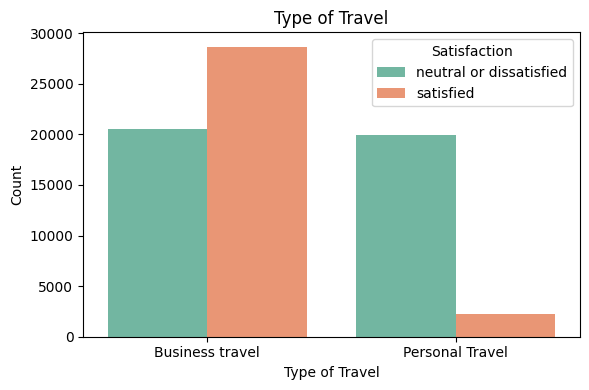

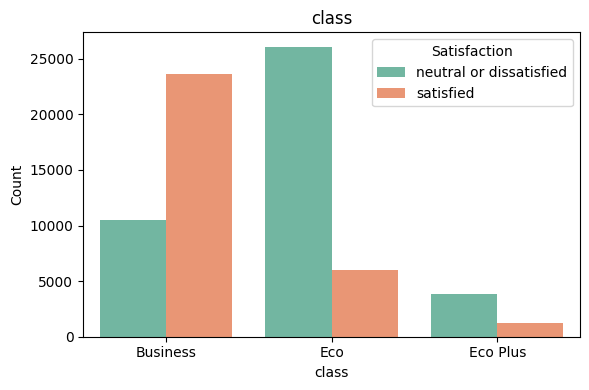

In [29]:
plot_categorical(categorical_cols, X_train, y_train)

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


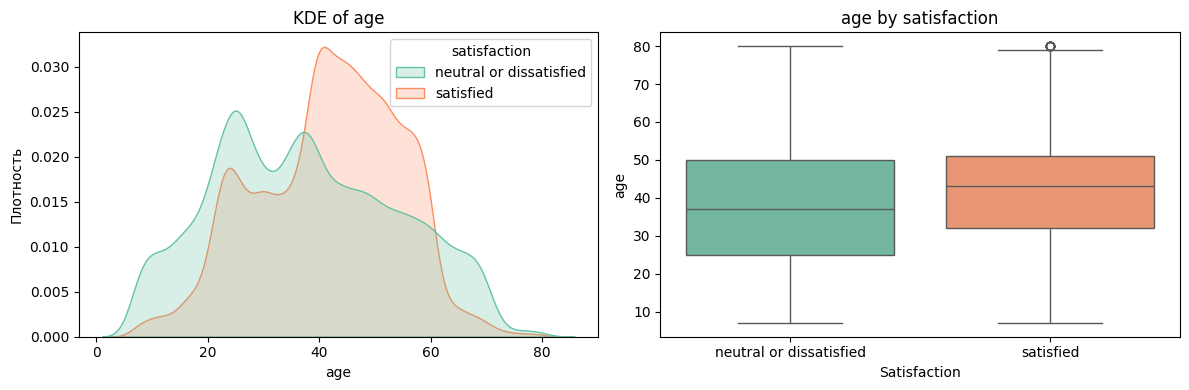

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


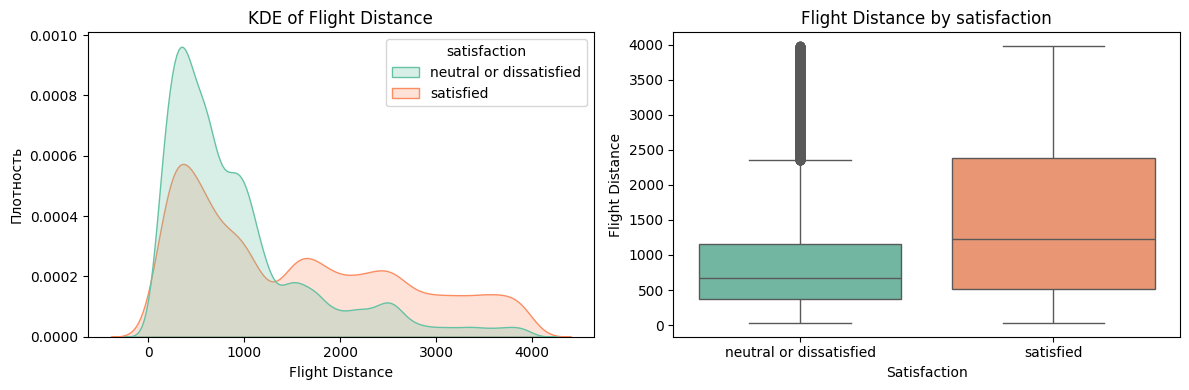

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


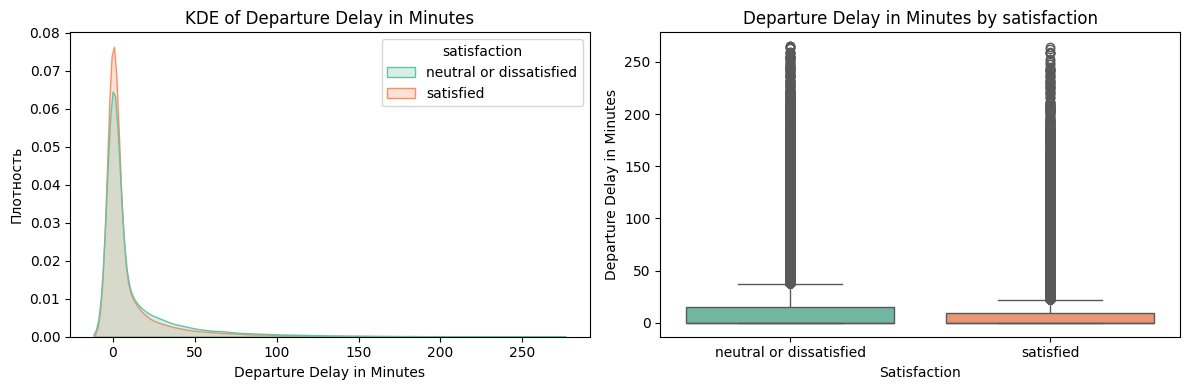

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


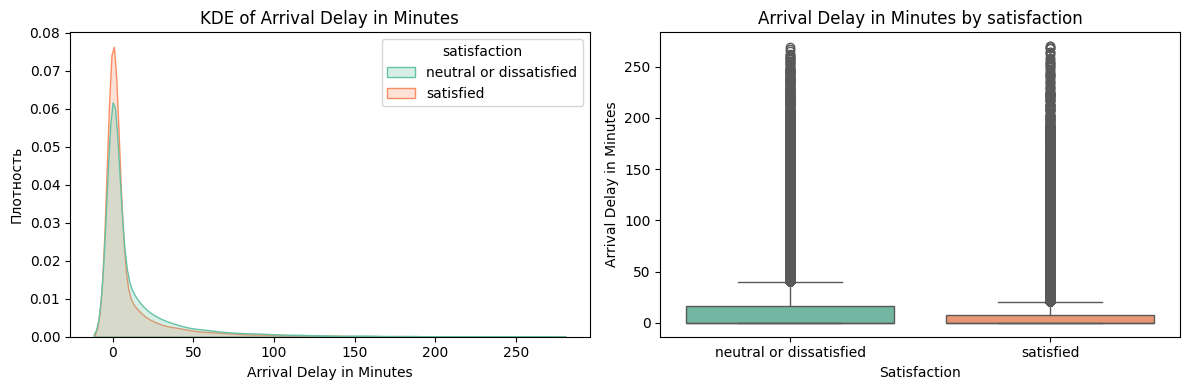

In [30]:
plot_continuous(continuous_cols, X_train, y_train)

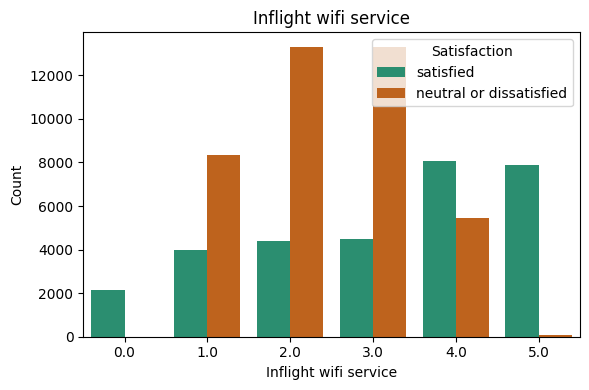

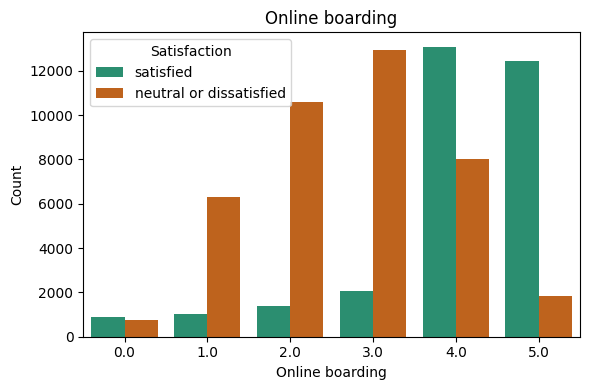

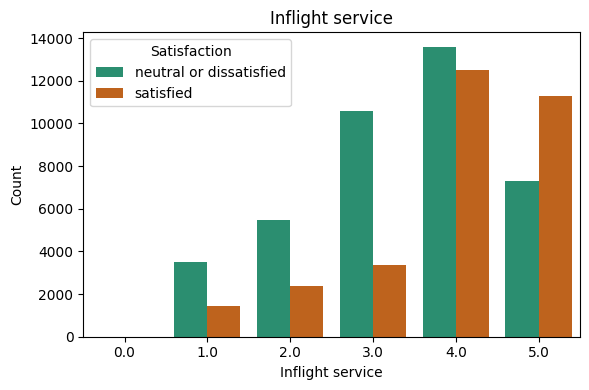

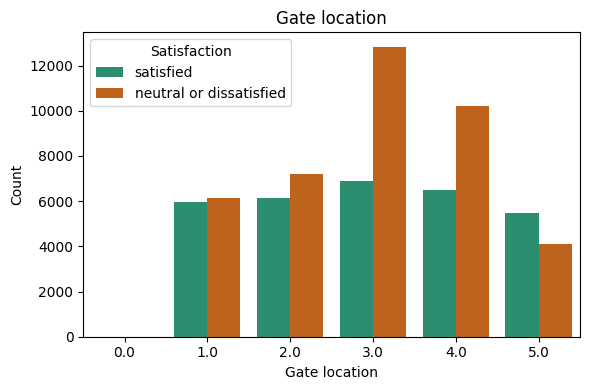

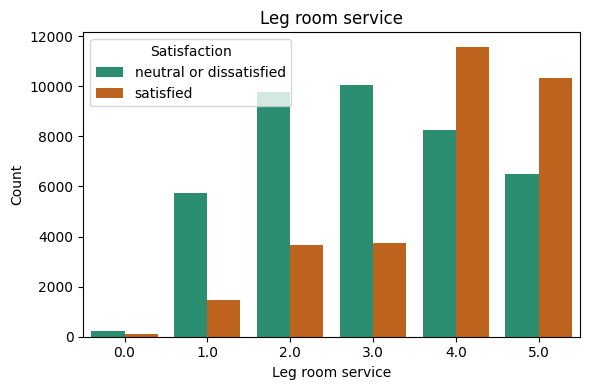

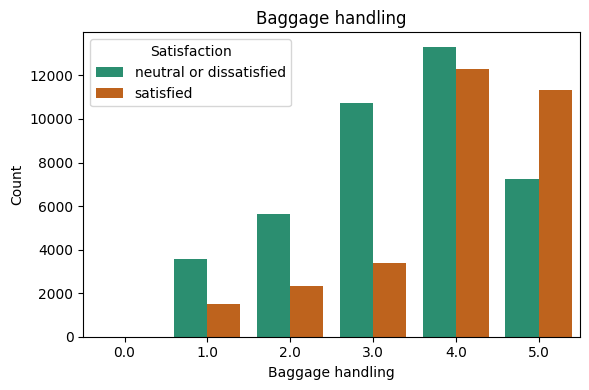

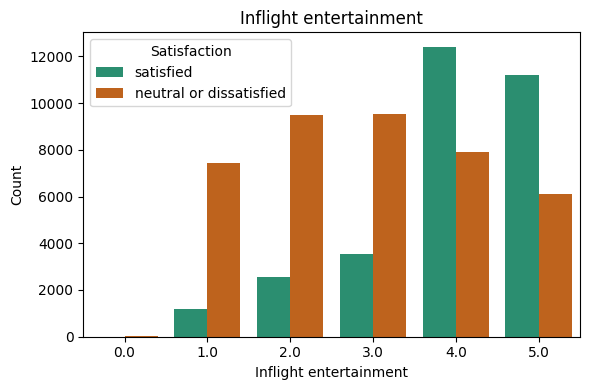

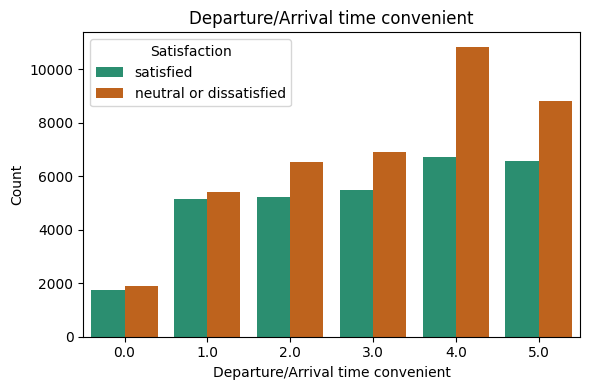

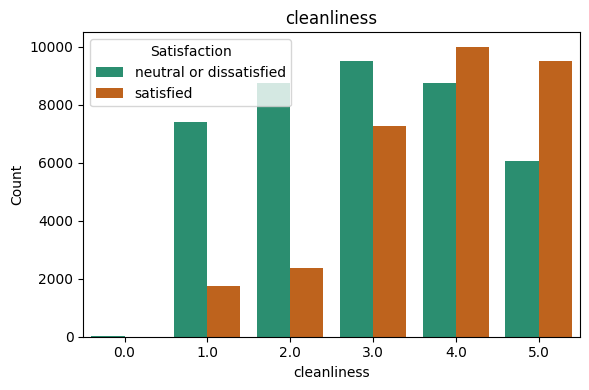

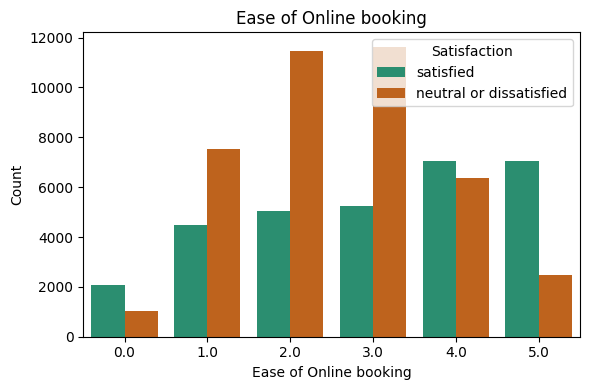

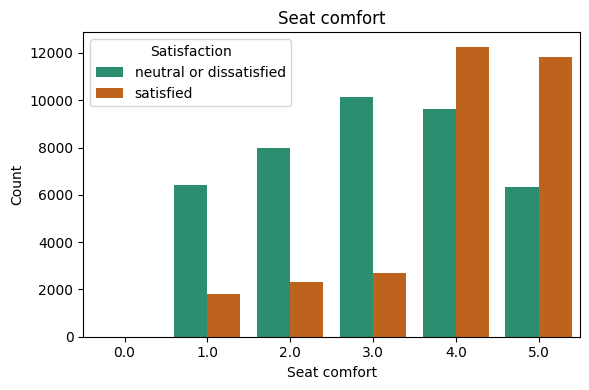

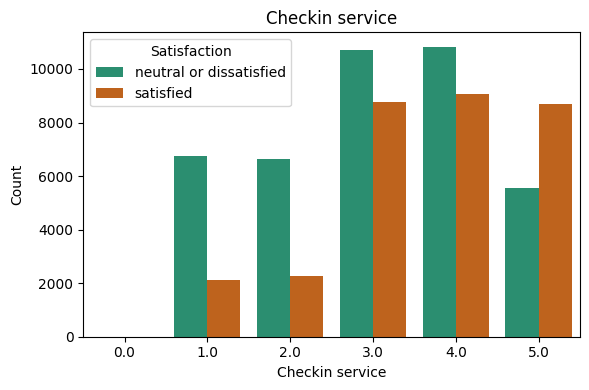

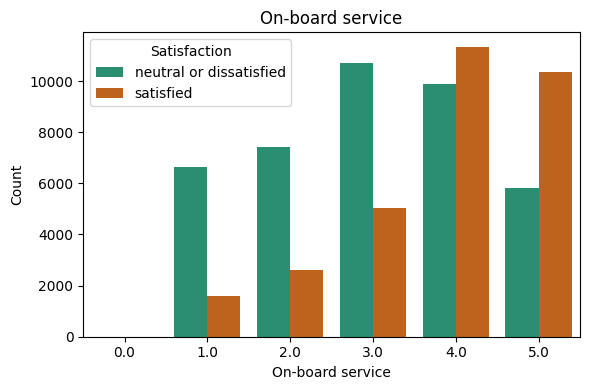

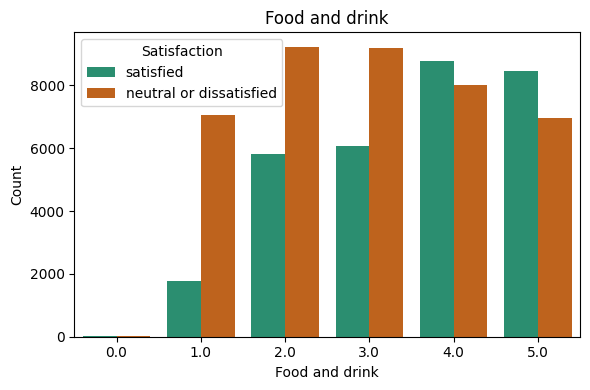

In [31]:
plot_ordinal(ordinal_cols, X_train, y_train)

<ipython-input-32-b97bbdf34c5f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


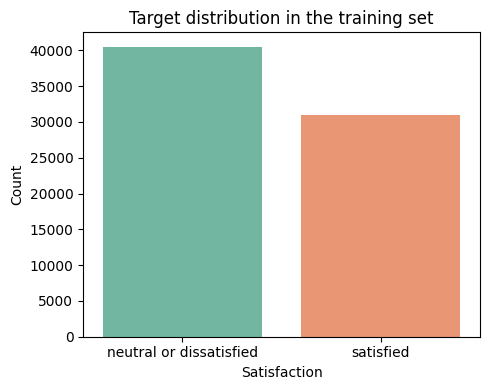

In [32]:
plt.figure(figsize=(5, 4))
sns.countplot(x=y_train, palette='Set2')
plt.title('Target distribution in the training set')
plt.xlabel('Satisfaction')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
Ваш ответ здесь
```
Удовлетворенность пассажиров зависит от их лояльности, класса обслуживания, типа путешествия, задержек рейсов и качества сервисов

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [33]:
for df_ in [X_train, X_val]:
    df_['Departure Delay in Minutes'] = np.log1p(df_['Departure Delay in Minutes'])
    df_['Arrival Delay in Minutes']   = np.log1p(df_['Arrival Delay in Minutes'])

Построение.

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


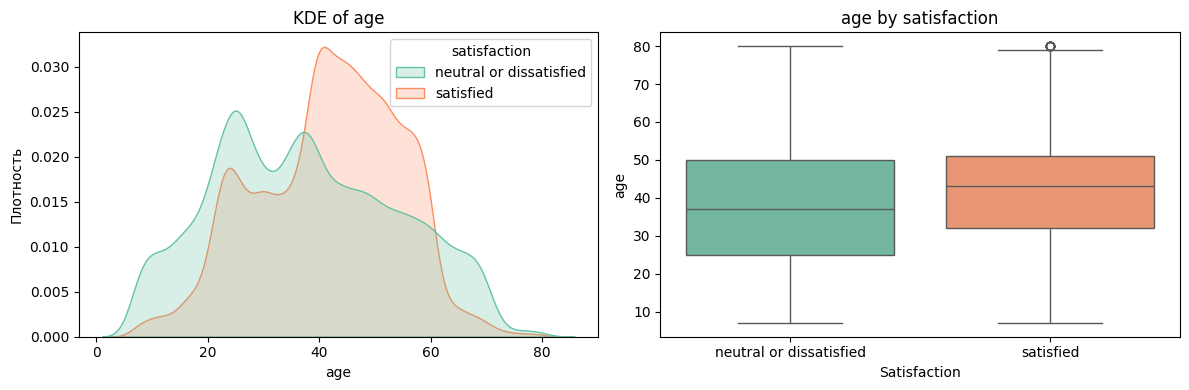

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


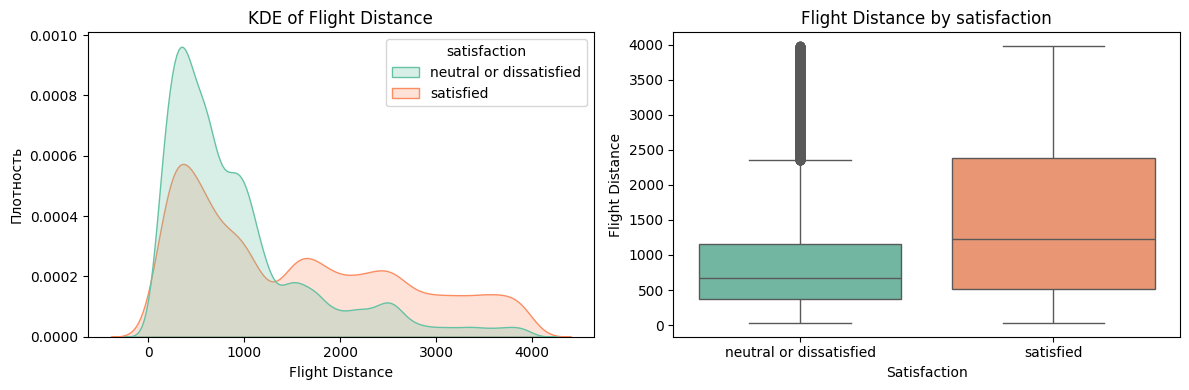

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


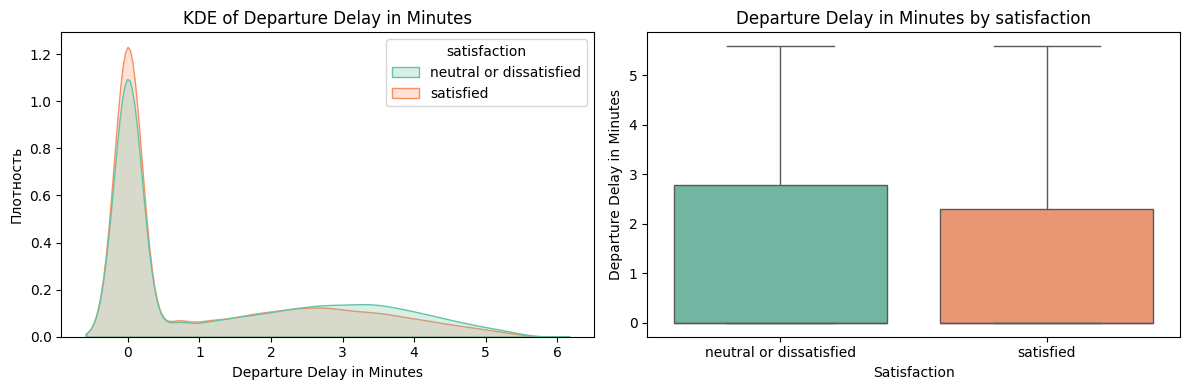

<ipython-input-27-5906c33311d4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, palette='Set2', ax=axes[1])


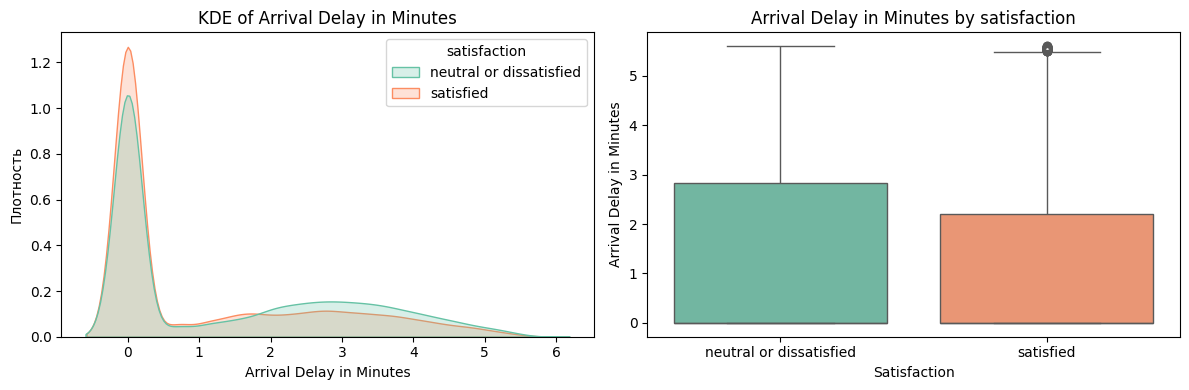

In [34]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

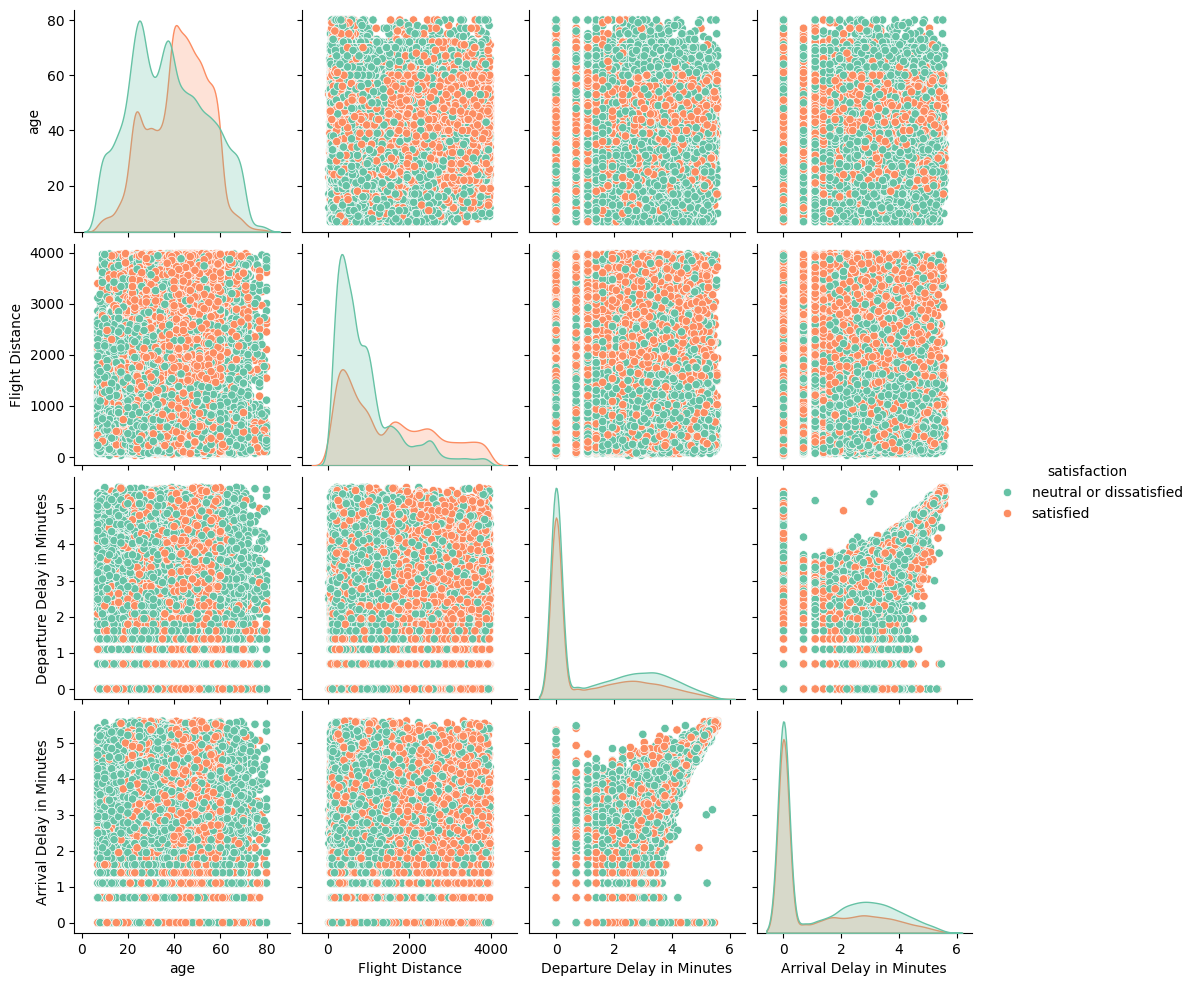

In [35]:
df_for_plot = X_train[continuous_cols].copy()
df_for_plot['satisfaction'] = y_train.values

sns.pairplot(df_for_plot, hue='satisfaction', diag_kind='kde', corner=False, palette='Set2')
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [36]:
y_train_enc = (y_train == 'satisfied').astype(int)
y_val_enc   = (y_val   == 'satisfied').astype(int)

In [37]:
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
X_val_enc   = pd.get_dummies(X_val,   columns=categorical_cols, drop_first=False)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [38]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train_enc, y_train_enc)

y_pred_val = dt_default.predict(X_val_enc)
acc_val = accuracy_score(y_val_enc, y_pred_val)

print(f"Точность: {acc_val:.4f}")

Точность: 0.9439


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [39]:
dt_for_bv = DecisionTreeClassifier(random_state=42)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    estimator=dt_for_bv,
    X_train=np.array(X_train_enc),
    y_train=np.array(y_train_enc),
    X_test=np.array(X_val_enc),
    y_test=np.array(y_val_enc),
    loss='0-1_loss',
    random_seed=42,
    num_rounds=50
)

print("Ошибка:", avg_expected_loss)
print("AVG bias:", avg_bias)
print("AVG variance:", avg_var)

Ошибка: 0.05945476829308688
AVG bias: 0.03965020371658551
AVG variance: 0.04373116035642122


### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [40]:
print("Глубина:", dt_default.get_depth())
print("Число листьев:", dt_default.get_n_leaves())

Глубина: 33
Число листьев: 2802


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

<ipython-input-41-6cb2014846e3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances.values[:20],


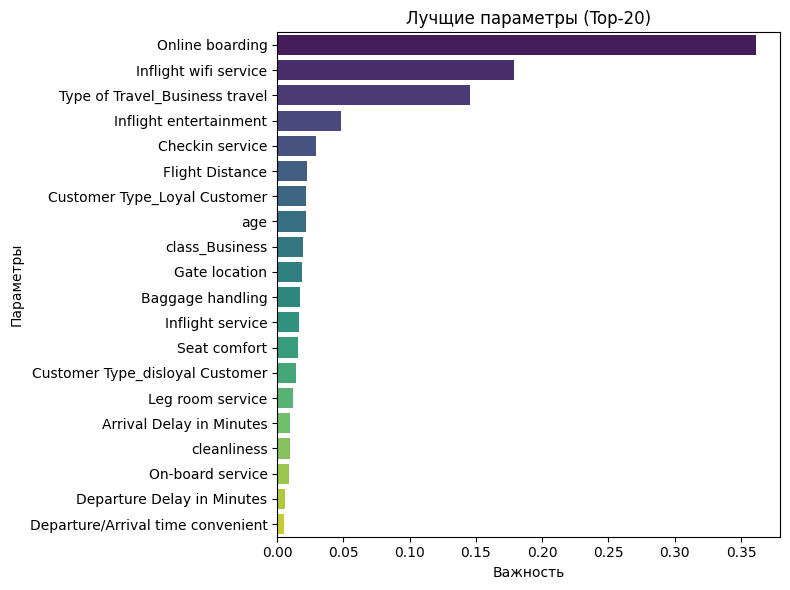

In [41]:
feat_importances = pd.Series(dt_default.feature_importances_, index=X_train_enc.columns)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importances.values[:20],
            y=feat_importances.index[:20],
            palette="viridis")
plt.title("Лучщие параметры (Top-20)")
plt.xlabel("Важность")
plt.ylabel("Параметры")
plt.tight_layout()
plt.show()


`Ваш ответ здесь.`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [42]:
top2 = feat_importances.index[:2]
X_train_top2 = X_train_enc[top2]
X_val_top2   = X_val_enc[top2]

dt_top2 = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_top2.fit(X_train_top2, y_train_enc)

acc_val_top2 = accuracy_score(y_val_enc, dt_top2.predict(X_val_top2))
print(f"Точность: {acc_val_top2:.4f}")

Точность: 0.8251


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

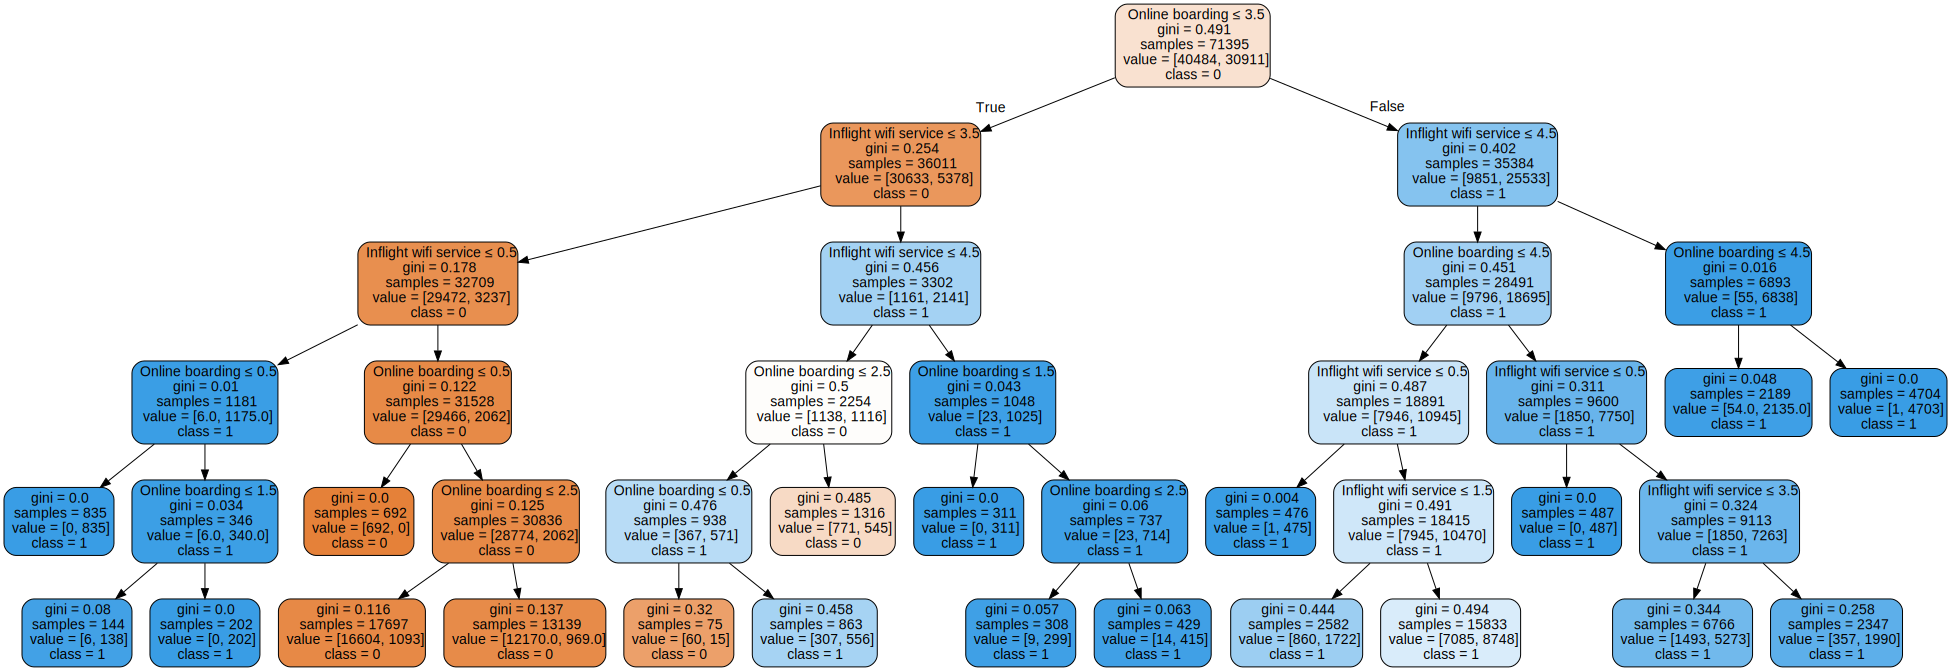

In [43]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(
    dt_top2,
    out_file=None,
    feature_names=top2,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph


Предикаты кратны 1/2, потому что дерево решений выбирает порог между соседними значениями данных для лучшего разделения.
*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

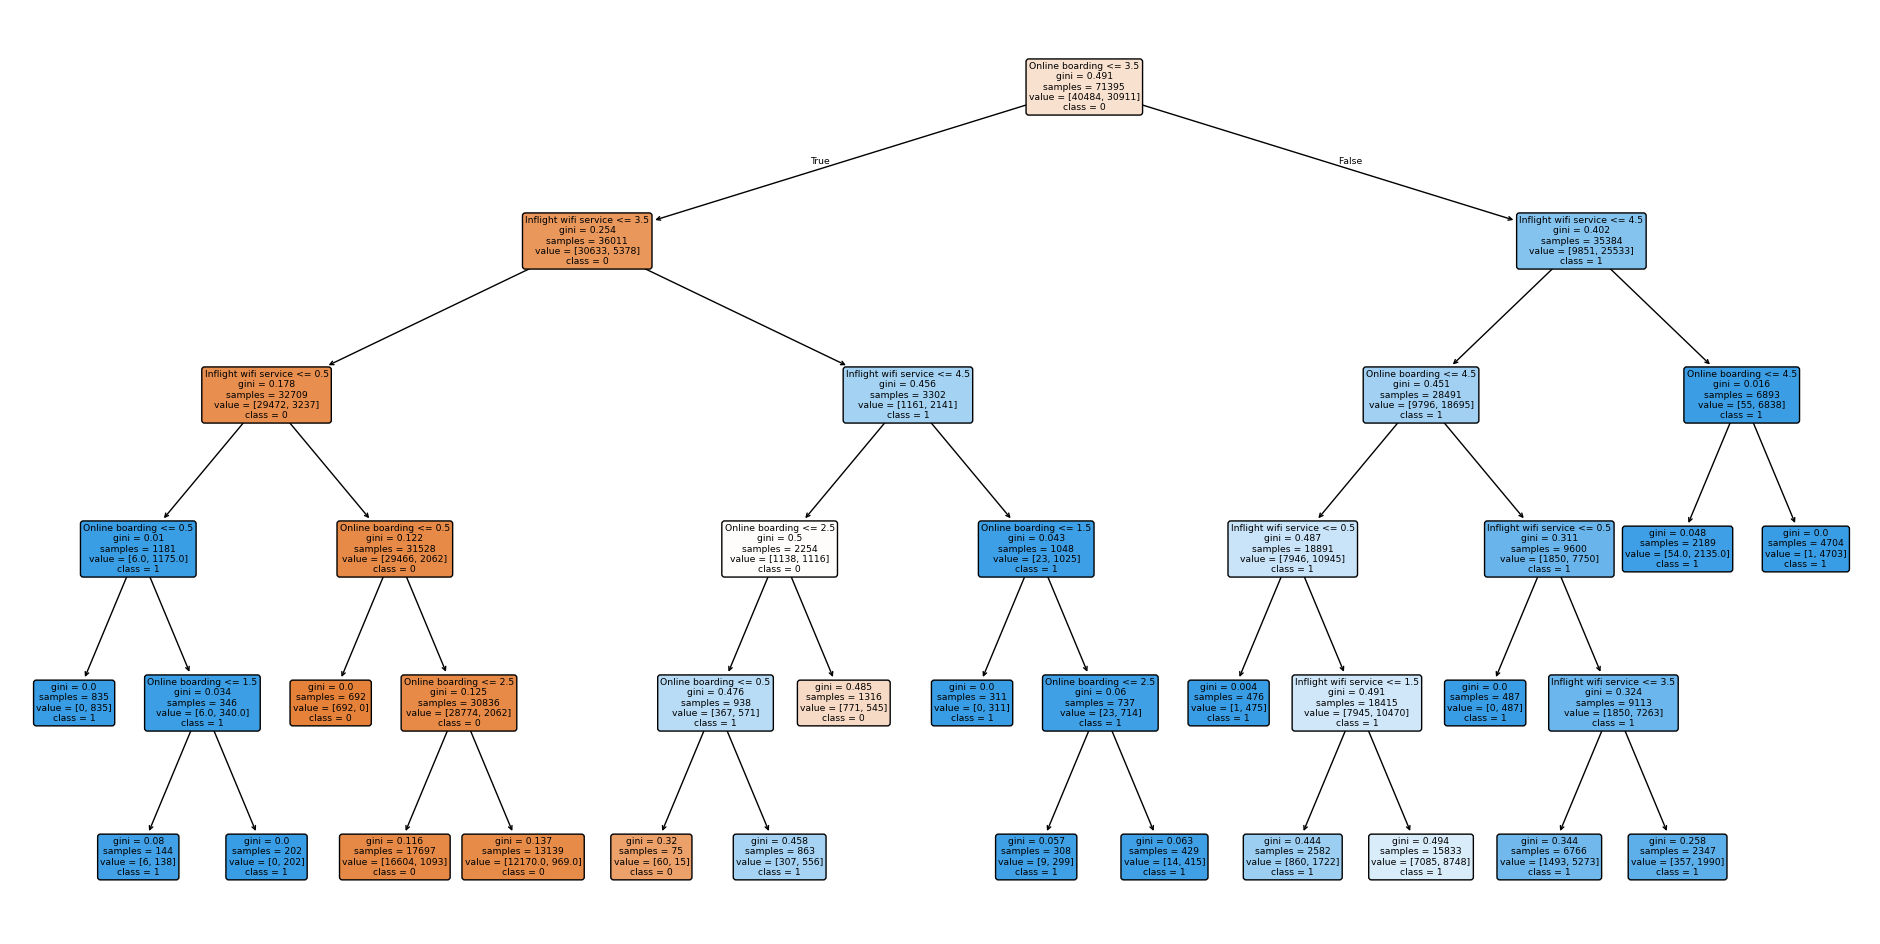

In [44]:
plt.figure(figsize=(24, 12))
tree.plot_tree(dt_top2,
               feature_names=top2,
               class_names=["0", "1"],
               filled=True,
               rounded=True)
plt.show()



Дерево не семетрично. Семетрия не является целью дерева, так что нету разницы, дерево просто делает разбиение для снижения загрязнености.

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


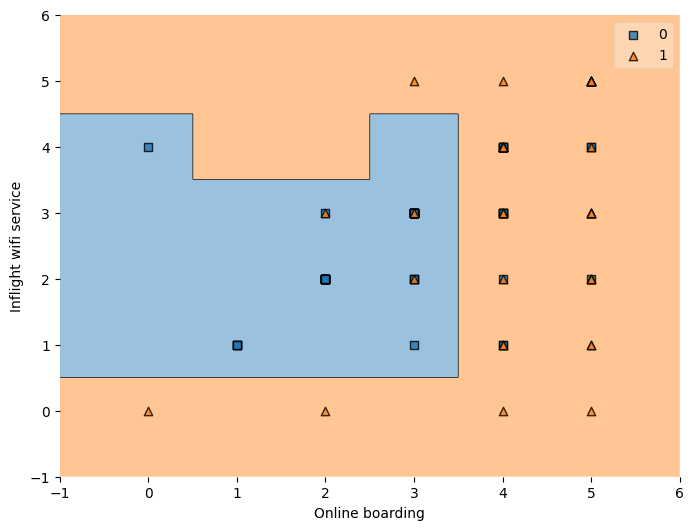

In [45]:
X_plot = np.array(X_train_top2.iloc[:100, :])
y_plot = np.array(y_train_enc.iloc[:100])

plt.figure(figsize=(8,6))
plot_decision_regions(X_plot, y_plot, clf=dt_top2)
plt.xlabel(top2[0])
plt.ylabel(top2[1])
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [46]:
X_train_example = X_train_top2.copy()
y_train_int = (y_train == 'satisfied').astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

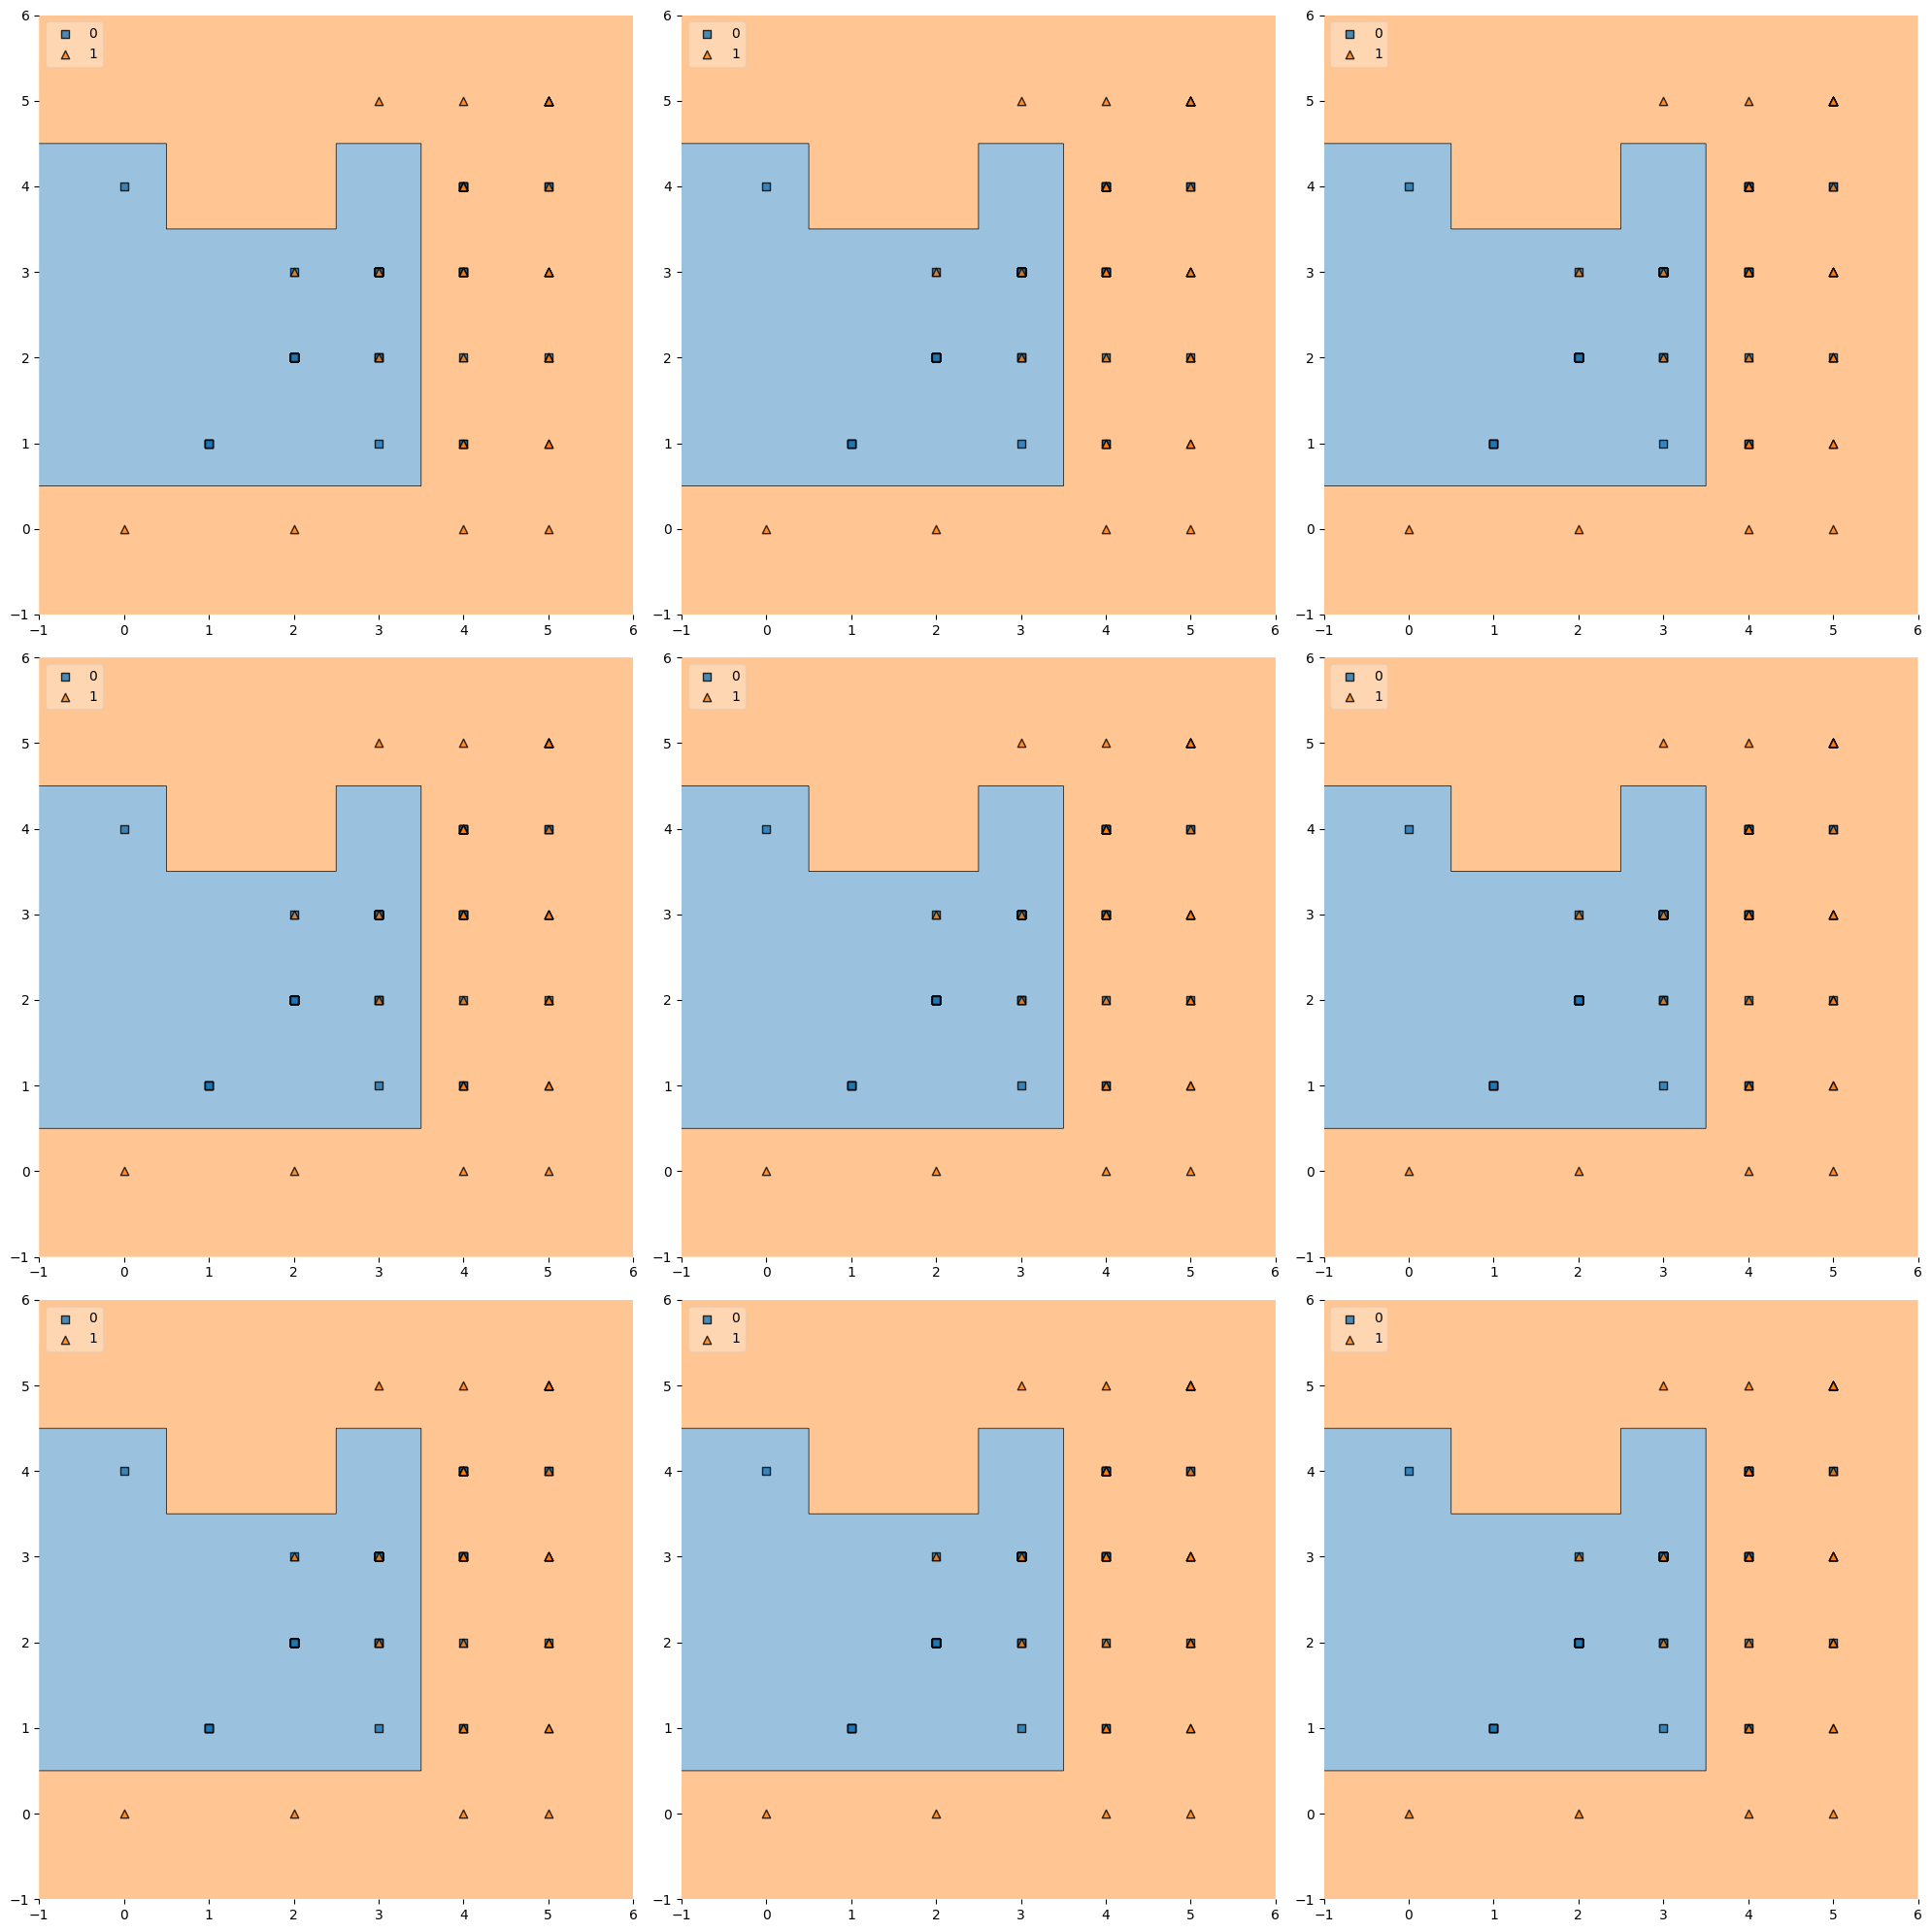

In [47]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False)
        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train_int.loc[inds])
        X_plot = X_train_example.iloc[:100, :].values
        y_plot = y_train_int.iloc[:100].values
        plot_decision_regions(clf=tree_exp, X=X_plot, y=y_plot,  ax=ax[row][col],legend=2)

plt.tight_layout()
plt.show()

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [48]:

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 13.9 s, sys: 35.8 ms, total: 13.9 s
Wall time: 13.9 s


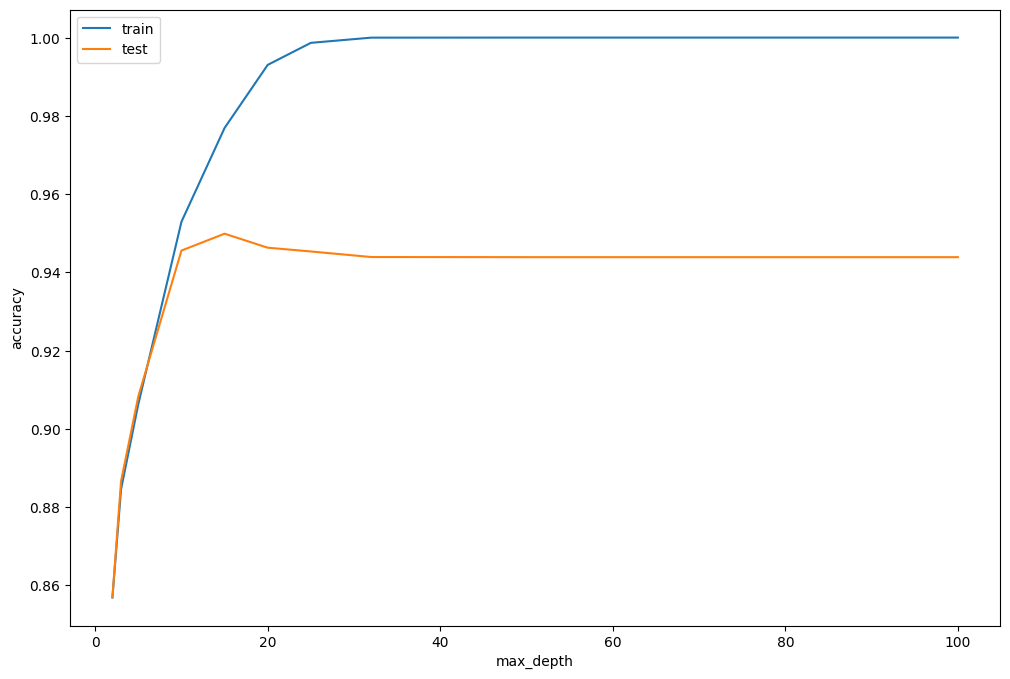

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 3, 5],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_enc, y_train_enc)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший CV :", grid_search.best_score_)

best_dt = grid_search.best_estimator_

val_pred = best_dt.predict(X_val_enc)
acc_val_best = accuracy_score(y_val_enc, val_pred)
print(f"Точность: {acc_val_best:.4f}")



Fitting 3 folds for each of 90 candidates, totalling 270 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10}
Лучший CV : 0.9469010413116087
Точность: 0.9485


### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [51]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_dt, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [52]:
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_enc, y_train_enc)

y_pred_val_rf = rf_default.predict(X_val_enc)
acc_rf = accuracy_score(y_val_enc, y_pred_val_rf)
print(f"Точность: {acc_rf:.4f}")

Точность: 0.9634


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

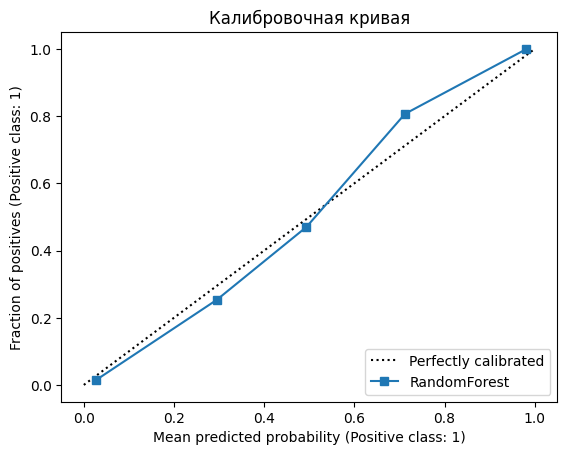

In [53]:
y_val_proba_rf = rf_default.predict_proba(X_val_enc)[:, 1]

CalibrationDisplay.from_predictions(y_val_enc, y_val_proba_rf, name='RandomForest')
plt.title("Калибровочная кривая")
plt.show()


Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Деревья решений плохо предсказывают вероятности, потому что они дают резкие скачки в предсказаниях, так как в листах оказываются конкретные объекты, и вероятность просто равна доле класса в листе. Часто бывают слишком уверенными в своих предсказаниях, даже если данных мало.

```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


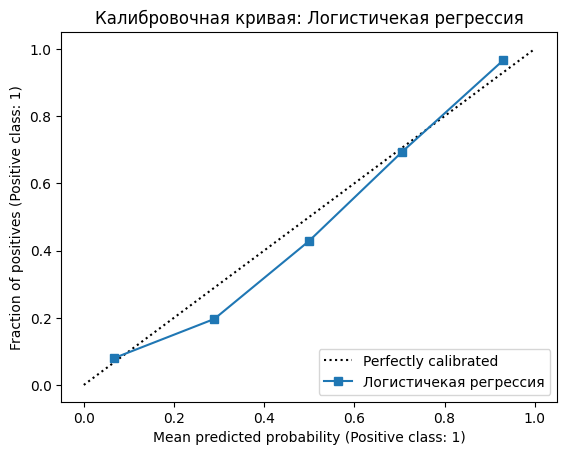

In [54]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_enc, y_train_enc)

y_val_proba_lr = lr.predict_proba(X_val_enc)[:, 1]

CalibrationDisplay.from_predictions(y_val_enc, y_val_proba_lr, name='Логистичекая регрессия')
plt.title("Калибровочная кривая: Логистичекая регрессия")
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Логистическая регрессия работает с вероятностями, потому что она специально обучается предсказывать вероятности — её функция потерь наказывает за слишком уверенные, но неверные прогнозы. Использует сигмоиду — это функция, которая сжимает любые числа в диапазон от 0 до 1, превращая их в вероятности.

```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

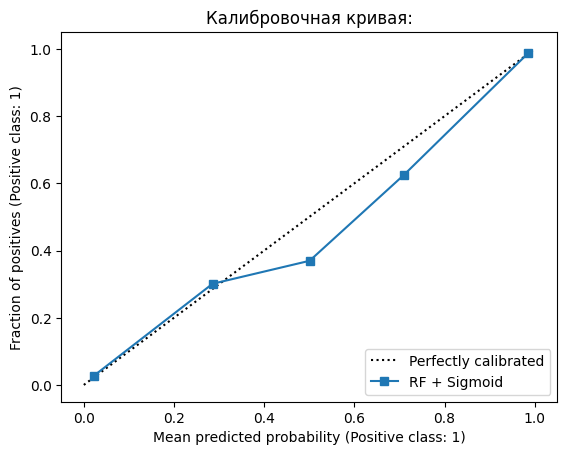

In [55]:
rf_sigmoid = CalibratedClassifierCV(estimator=rf_default, method='sigmoid', cv=5)
rf_sigmoid.fit(X_train_enc, y_train_enc)

y_val_proba_sigmoid = rf_sigmoid.predict_proba(X_val_enc)[:, 1]
CalibrationDisplay.from_predictions(y_val_enc, y_val_proba_sigmoid, name='RF + Sigmoid')
plt.title("Калибровочная кривая:")
plt.show()

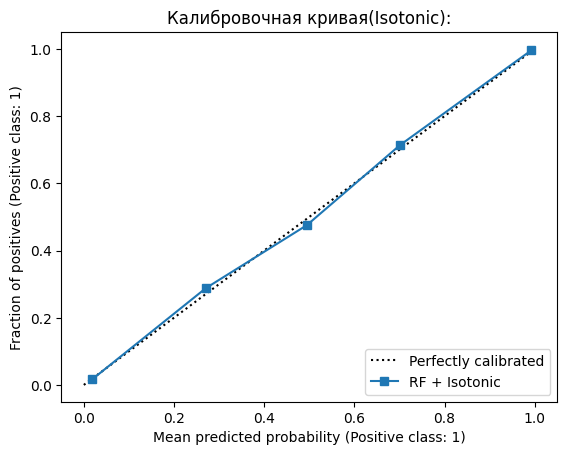

In [56]:
rf_isotonic = CalibratedClassifierCV(estimator=rf_default, method='isotonic', cv=5)
rf_isotonic.fit(X_train_enc, y_train_enc)

y_val_proba_iso = rf_isotonic.predict_proba(X_val_enc)[:, 1]
CalibrationDisplay.from_predictions(y_val_enc, y_val_proba_iso, name='RF + Isotonic')
plt.title("Калибровочная кривая(Isotonic):")
plt.show()

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

Гистограммная калибровка: разделяет предсказанные вероятности на интервалы (бины) и корректирует их на основе частот наблюдений в каждом интервале. https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti

Калибровка Платта: использует логистическую регрессию для преобразования выходных значений модели в откалиброванные вероятности. https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [57]:
rf_for_bv = RandomForestClassifier(random_state=42)
rf_for_bv.fit(X_train_enc, y_train_enc)

avg_expected_loss_rf, avg_bias_rf, avg_var_rf = bias_variance_decomp(
    estimator=rf_for_bv,
    X_train=X_train_enc.to_numpy(),
    y_train=y_train_enc.to_numpy(),
    X_test=X_val_enc.to_numpy(),
    y_test=y_val_enc.to_numpy(),
    loss='0-1_loss',
    random_seed=42,
    num_rounds=50
)

print("  avg expected loss:", avg_expected_loss_rf)
print("  avg bias:", avg_bias_rf)
print("  avg variance:", avg_var_rf)

  avg expected loss: 0.038656464275067075
  avg bias: 0.03700023187253636
  avg variance: 0.008473284971347179



```
Ваш ответ здесь
```

Разброс уменьшился почти в 3 раза, а общая ошибка тоже значительно снизилась. Это полностью соответствует теории случайного леса, который использует ансамбль деревьев, снижая переобучение и делая предсказания более стабильными. Благодаря усреднению решений нескольких деревьев лес действительно показывает более низкий variance и сохраняет низкое смещение

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [58]:
lr_for_bv = LogisticRegression(random_state=42, max_iter=1000)
lr_for_bv.fit(X_train_enc, y_train_enc)

avg_expected_loss_lr, avg_bias_lr, avg_var_lr = bias_variance_decomp(
    estimator=lr_for_bv,
    X_train=X_train_enc.to_numpy(),
    y_train=y_train_enc.to_numpy(),
    X_test=X_val_enc.to_numpy(),
    y_test=y_val_enc.to_numpy(),
    loss='0-1_loss',
    random_seed=42,
    num_rounds=50
)

print("  avg expected loss:", avg_expected_loss_lr)
print("  avg bias:", avg_bias_lr)
print("  avg variance:", avg_var_lr)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

  avg expected loss: 0.12400145748451424
  avg bias: 0.12408493159760177
  avg variance: 0.004524826923713935


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [59]:
from scipy.stats import randint, uniform
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 30),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.3, 0.7),  # от 0.3 до 1.0
}

rf_rnd = RandomForestClassifier(random_state=42)

rnd_search = RandomizedSearchCV(
    estimator=rf_rnd, param_distributions=param_distributions, n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1,verbose=1)

rnd_search.fit(X_train_enc, y_train_enc)

print("Лучшие параметры:", rnd_search.best_params_)
print("Лучшаяточность в CV:", rnd_search.best_score_)

best_rf = rnd_search.best_estimator_

y_val_pred = best_rf.predict(X_val_enc)
acc_val_best_rf = accuracy_score(y_val_enc, y_val_pred)
print(f"Точность валидации: {acc_val_best_rf:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие параметры: {'max_depth': 26, 'max_features': 0.5038603981386294, 'min_samples_leaf': 3, 'n_estimators': 157}
Лучшаяточность в CV: 0.9619861366067276
Точность валидации: 0.9636


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [60]:
cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

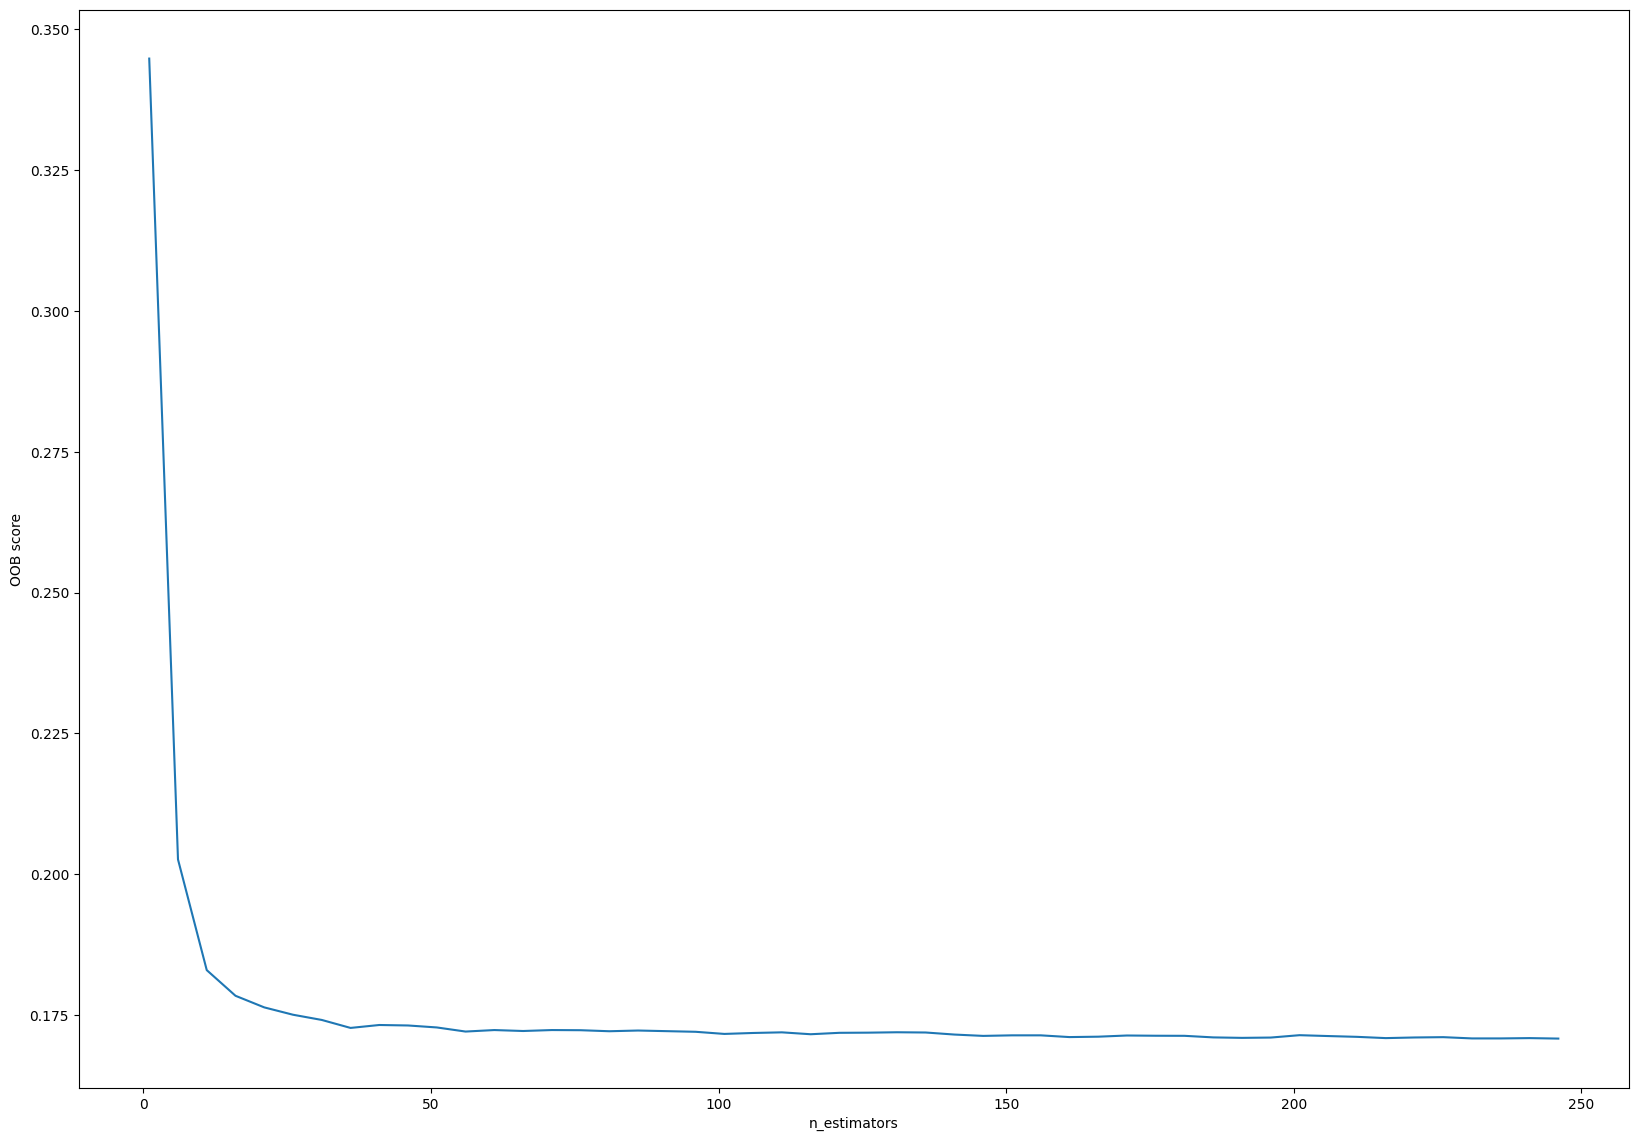

In [61]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


<ipython-input-62-465082644757>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances_rf.values[:20], y=feat_importances_rf.index[:20], palette="viridis")


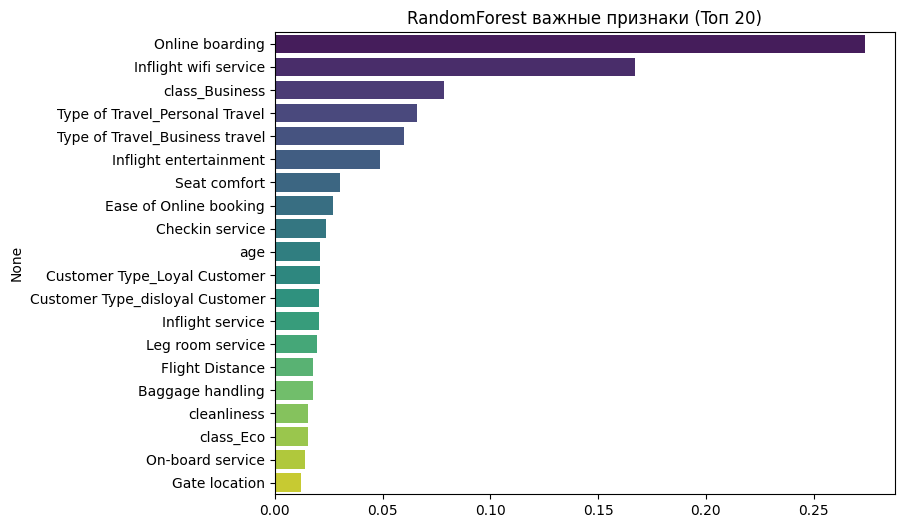

In [62]:
feat_importances_rf = pd.Series(best_rf.feature_importances_, index=X_train_enc.columns)
feat_importances_rf = feat_importances_rf.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importances_rf.values[:20], y=feat_importances_rf.index[:20], palette="viridis")
plt.title("RandomForest важные признаки (Toп 20)")
plt.show()

In [63]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [64]:
import pickle

with open("best_rf.pkl", "wb") as f:
    pickle.dump(best_rf, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

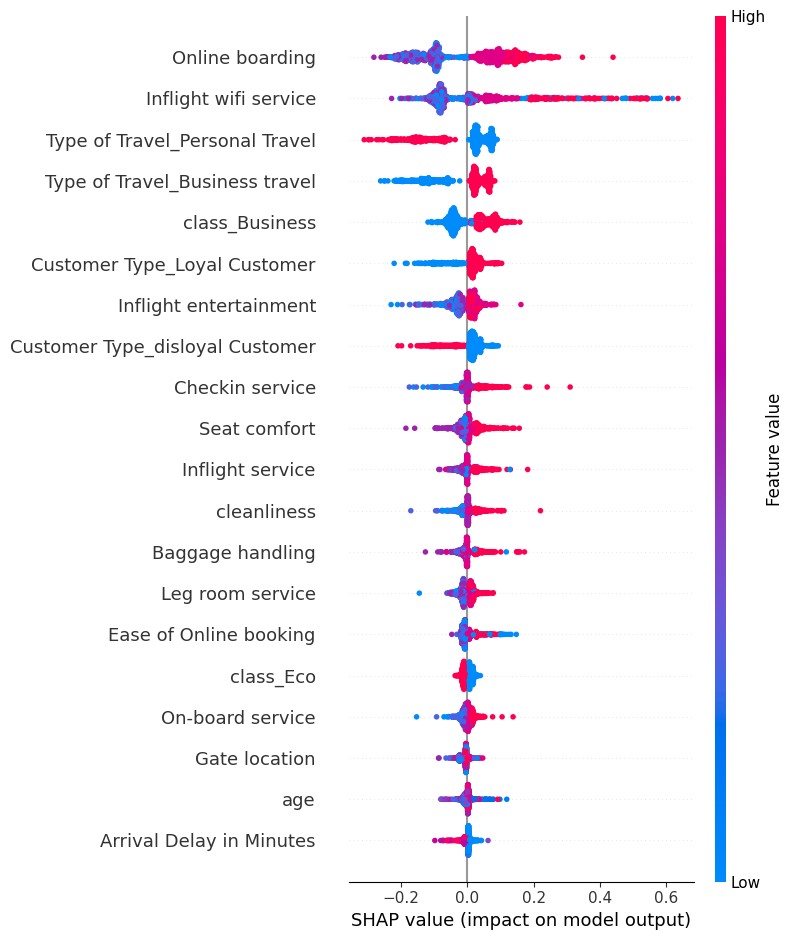

In [70]:
import shap
sample_X = np.random.choice(len(X_train_enc), 1000, replace=False)
X_sample = X_train_enc.iloc[sample_X]
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)
shap_values_for_class1 = shap_values[..., 1]

shap.summary_plot(shap_values_for_class1, X_sample, plot_type="dot")
plt.show()


`Ваш ответ здесь`
Резульататы аналогичны прошлому исследованию важности признаков первого леса, за исключением того - что важных признаков стало больше. Было 3, стало 6, что является хорошим показателем (обычно)

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

Много графиков, красивые нагляддные например: waterfall plot, dependence plot, force plot, heatmap, dot plot и много много других

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


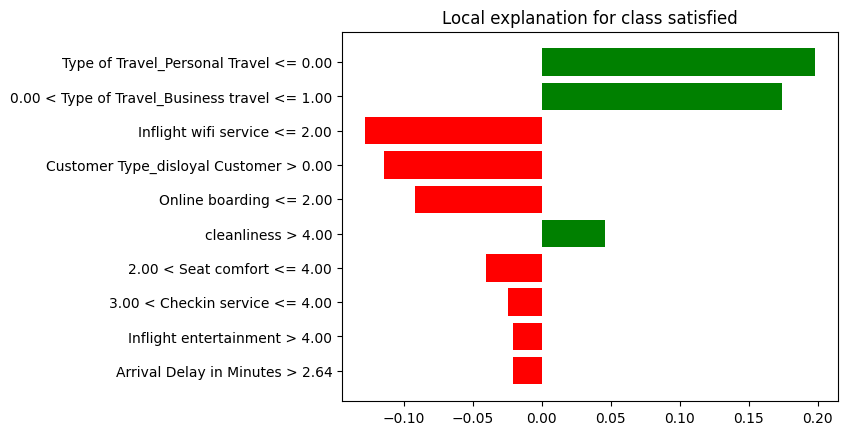

In [73]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_enc.values,
    feature_names=X_train_enc.columns.tolist(),
    class_names=['not satisfied', 'satisfied'],
    mode='classification',
    random_state=42
)

i = 42
x_val_row = X_val_enc.iloc[i].values

explanation = explainer.explain_instance(
    data_row=x_val_row,
    predict_fn=best_rf.predict_proba,
    num_features=10
)


fig = explanation.as_pyplot_figure()
plt.show()


График показывает, что для данного пассажира наибольшее влияние на удовлетворённость оказали тип поездки (Personal Travel) и чистота, увеличивая вероятность быть довольным, а плохой Wi-Fi, неудобная онлайн-регистрация и задержка прибытия снизили вероятность удовлетворённости.

## Котобонус!

0.25 балла

Сабрины?)? Ну если не она, то я уверен, что хозяин хороший человек и его кот великолепен!!!

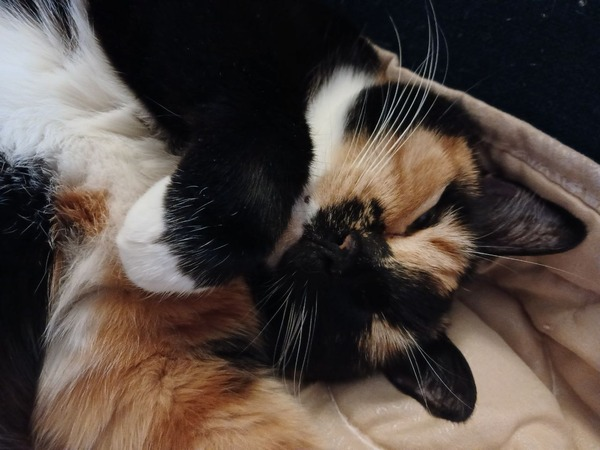

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

In [ ]:
Дз хорошее, единственное часть кода по 15-20 минут выполнялось... Но а так, как всегда на высоте!